# Cyberbullying On Social Media

# Feature Engineering

In [1]:
# dependencies
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from collections import Counter

import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import warnings 
import seaborn as sns 

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA


import gensim
from gensim.models.doc2vec import TaggedDocument


import multiprocessing

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline
# ! pip install imbalanced-learn
# check version number
import imblearn
# print(imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

# ! pip install ipympl
# %matplotlib widget

In [2]:
df = pd.read_csv('labeled_insta_cleaned.csv', encoding = 'utf-8-sig', engine = 'python')

In [3]:
comments = df['tidy_text']
labels = df['label_bullying']

In [4]:
#keep the same random state for reproducibility
RANDOM_STATE_SMOTE = 12
RANDOM_STATE = 1000
TRAIN_TEST_SPLIT_SIZE = .1
VALIDATION_SPLIT_SIZE = .2

In [5]:
neg, pos = np.bincount(df['label_bullying'])
total = neg + pos
print('Samples in entire dataset:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Samples in entire dataset:
    Total: 11033
    Positive: 3183 (28.85% of total)



In [6]:
wpt = nltk.WordPunctTokenizer()
tokenized_comments = [wpt.tokenize(comment) for comment in comments]

In [7]:
x_train_val, x_test, y_train_val, y_test = train_test_split(tokenized_comments, labels,
                                                  test_size = TRAIN_TEST_SPLIT_SIZE, stratify = labels,
                                                  random_state = RANDOM_STATE)

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val,
                                                  test_size = VALIDATION_SPLIT_SIZE, stratify = y_train_val,
                                                  random_state = RANDOM_STATE)

In [9]:
neg, pos = np.bincount(y_train)
total = neg + pos
print('Samples in train dataset:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Samples in train dataset:
    Total: 7943
    Positive: 2291 (28.84% of total)



In [10]:
neg, pos = np.bincount(y_test)
total = neg + pos
print('Samples in test dataset:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Samples in test dataset:
    Total: 1104
    Positive: 319 (28.89% of total)



In [11]:
neg, pos = np.bincount(y_val)
total = neg + pos
print('Samples in validation dataset:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Samples in validation dataset:
    Total: 1986
    Positive: 573 (28.85% of total)



In [12]:
np.save("train_dataset_features.npy", np.array(x_train))
np.save("train_dataset_labels.npy", np.array(y_train))

In [13]:
np.save("test_dataset_features.npy", np.array(x_test))
np.save("test_dataset_labels.npy", np.array(y_test))

In [14]:
np.save("val_dataset_features.npy", np.array(x_val))
np.save("val_dataset_labels.npy", np.array(y_val))

**Feature Extraction from Text**

To analyse a preprocessed data, it needs to be converted into features. Since numerical features ease the processing and statistical analysis, most machine learning algorithms require a numerical representation of objects as features. For this reason, feature extraction techniques are employed to convert the textual data into numerical features. The most popular and simple methods of feature extraction with text data currently used are:

- Bag of Words
- TF-IDF
- Word embeddings


**TF-IDF**

Defition according to Wikipedia: “Term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.” 

The widely used feature extraction technique that in the past was traditionally used for text is TF-IDF. This technique has been proven to work well with text data and traditional algorithms and is also quite explainable. TF-IDF generates features of size N x V, where N is the number of observations and V is the vocabulary size. This approach can help reduce the size of the features to the choice of embedding size.

The idea behind the TF-IDF approach is that the words that occur less in all the documents and more in individual document contribute more towards classification. TF-IDF is a combination of two terms. Term frequency and Inverse Document frequency. TF is a measure of how frequently a term appears in a document. IDF is a measure of how important a term is. We need the IDF value because computing just the TF alone is not sufficient to understand the importance of words.

***

For the technical implementation I will use the TfidfVectorizer from scikit-learn.


TfidfVectorizer has a few important parameters: 
- stop_words:  Stop words are just a list of words we don’t want to use as features. This parameter defaults to None. In the preprocessing part, I already removed some of the stop words, so I will not use this parameter here.
- min_df parameter is a threshold value where we ignore terms that have a document frequency lower than min_df. If rare words only occur once or twice, they won't add much value and are usually really obscure. Furthermore, there's generally a lot of them so ignoring them with say min_df=5 can greatly reduce your memory consumption and data size. Generally putting min_df 5-10 is a good balance, because you also filter misspelled words. 
- max_df is the contrast of min_df parameter. If the document frequency of a word is more than max_df, we ignore it. max_df = 0.90 means "ignore terms that appear in more than 90% of the documents/less than 10% of the documents".
- max_features

Let's explore different parameters for feature extraction for count vectorizer to see the effect of the parameters. Logistic regression is a simple and fast classifier. Due to its simplicity, it’s often a good  classifier to try.

**Note:** Normally one would tune the parameters of the TF-IDF vectorizer together with the hyperparameters of the individual classifiers inside the pipeline, which is something I've tried to but turned out to be very computationally expensive, with up to 1200 parameters to tune inside a GridSearchCV, which is why I've decided to extract the features separately, and try to tune as much as possible here.

In [15]:
logreg = LogisticRegression()

In [16]:
skf = StratifiedKFold(n_splits = 5)

In [17]:
max_feature_params = [None, 500, 1000, 5000, 10000]
max_feature_score = []

for p in max_feature_params:
    tfidf_vectorizer = TfidfVectorizer(tokenizer = lambda x: x,
                        preprocessor = lambda x: x, max_features = p)

    tfidf = tfidf_vectorizer.fit_transform(x_train_val) 
    score = cross_val_score(logreg, tfidf, y_train_val, cv = skf, scoring = 'f1')
    max_feature_score.append(score.mean())

In [18]:
max_features = ['max_f=' + str(p) for p in max_feature_params]
# put everything in a dataframe
max_features_df = pd.DataFrame({'params':max_features, 'scores':max_feature_score}, index = [0,1,2,3,4])

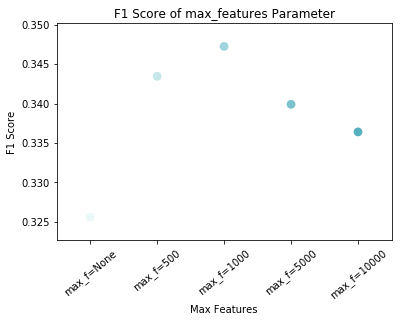

In [19]:
sns.pointplot(x ='params', y ='scores', data = max_features_df, palette = sns.light_palette((210, 90, 60), input = "husl"), markers = ["o"])
plt.ylabel('F1 Score')
plt.xlabel('Max Features')
plt.xticks(rotation = 40)
plt.title('F1 Score of max_features Parameter')
plt.show()

In [20]:
max_df_params = [0.5, 0.75, 0.8, 0.9, 1.0]
max_df_score = []

for p in max_df_params:
    tfidf_vectorizer = TfidfVectorizer(tokenizer = lambda x: x,
                        preprocessor = lambda x: x, max_df = p)

    tfidf = tfidf_vectorizer.fit_transform(x_train_val) 
    score = cross_val_score(logreg, tfidf, y_train_val, cv = skf, scoring = 'f1')
    max_df_score.append(score.mean())

In [21]:
max_dfs = ['max_df=' + str(p) for p in max_df_params]
# dataframe for scores
max_df_df = pd.DataFrame({'params':max_dfs, 'scores':max_df_score}, index = [0,1,2,3,4])

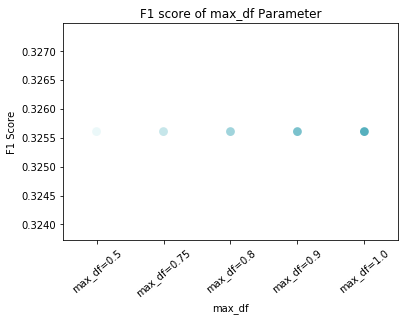

In [22]:
sns.pointplot(x = 'params', y = 'scores', data = max_df_df, palette = sns.light_palette((210, 90, 60), input = "husl"), markers = ["o"])
plt.ylabel('F1 Score')
plt.xlabel('max_df')
plt.xticks(rotation = 40)
plt.title('F1 score of max_df Parameter')
plt.show()

We see that specifying max_df does not seem to influence the results. So, I will use max_df=0.8 to control the maximum number of documents any term can be found in. If 80% of comments contain the same word then it’s so common that it’s not very useful. min_df set to 5, as per explanation above.

For the number of features, we see that an ideal number seems to be 1'000.

**Creating Bigram and Trigram Models**

I will use TF-IDF with an n-gram range of (1,3).

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring. Hopefully by adding ngram parameter, we are able to understand phrase like "not good" and other relevant combinations.

In [23]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = lambda x: x,
                        preprocessor = lambda x: x, 
                        min_df = 5, max_df = 0.8, max_features = 1000, ngram_range = (1,3)) 
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train) 
x_test_tfidf = tfidf_vectorizer.transform(x_test)
x_val_tfidf = tfidf_vectorizer.transform(x_val)

x_train_tfidf.shape

(7943, 1000)

In [24]:
len(tfidf_vectorizer.vocabulary_)

1000

In [25]:
# return a list of (term, score/frequency) pairs for each distinct term 
scores = np.asarray(x_train_tfidf.mean(axis = 0)).ravel().tolist()
scores_df = pd.DataFrame({'word': tfidf_vectorizer.get_feature_names(), 'tfidf': scores})
df_tfidf = scores_df.sort_values(by = 'tfidf', ascending = False).head(50)

In [26]:
df_tfidf

,word,tfidf
591,not,0.059004
367,hate,0.055567
195,damn,0.054489
306,fuck,0.052102
836,suck,0.040238
45,ass,0.039367
464,laugh,0.037760
319,get,0.037252
484,like,0.031895
507,loud,0.030512


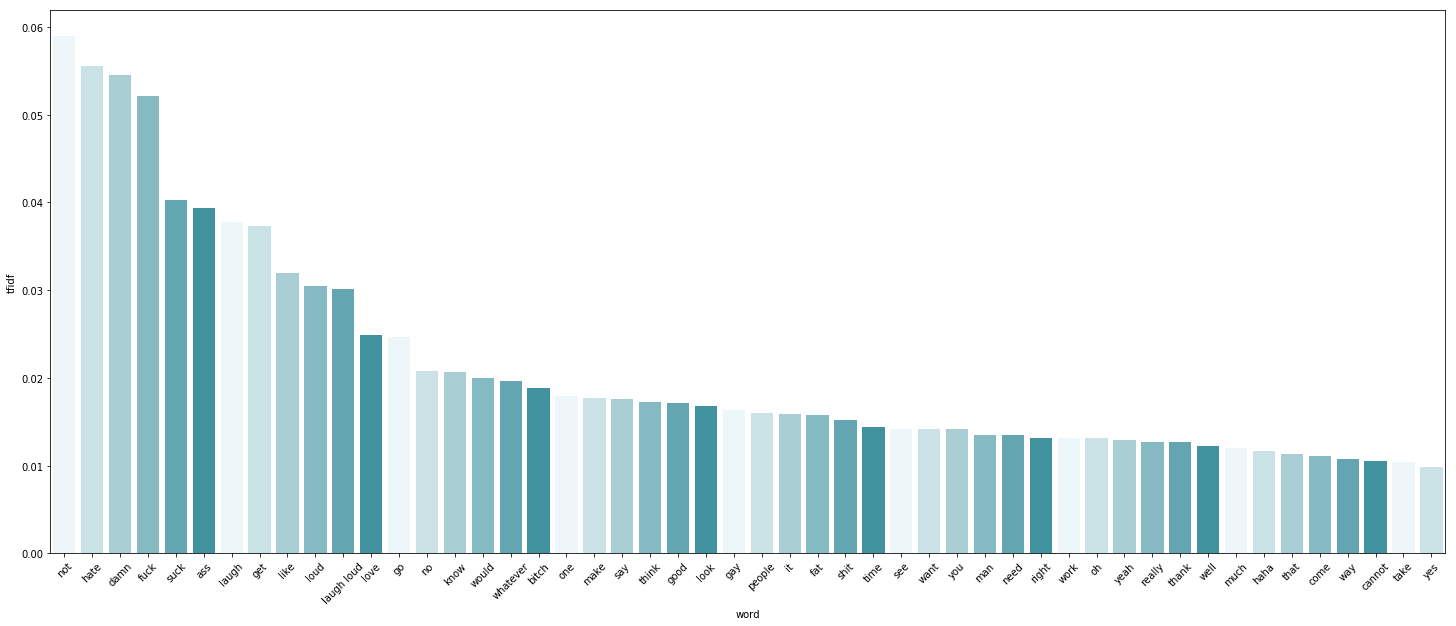

In [27]:
plt.figure(figsize = (25,10))
sns.barplot(x = 'word', y = 'tfidf', data = df_tfidf, palette = sns.light_palette((210, 90, 60), input = "husl"))
plt.xticks(rotation = 45)
plt.show()

For example we see here that by adding the ngrams we were able to capture "laugh loud" as one of the top words (and word combinations).

***

**Prepare features and apply SMOTE**

***

In [28]:
# transform the training dataset only
sm = SMOTE(random_state = RANDOM_STATE_SMOTE)
x_train_tfidf_sm, y_train_tfidf_sm = sm.fit_sample(x_train_tfidf, y_train)

In [29]:
# summarize class distribution
neg, pos = np.bincount(y_train_tfidf_sm)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 11304
    Positive: 5652 (50.00% of total)



In [30]:
np.save("train_dataset_tfidf_features.npy", np.array(x_train_tfidf_sm))
np.save("train_dataset_tfidf_labels.npy", np.array(y_train_tfidf_sm))

In [31]:
np.save("val_dataset_tfidf_features.npy", np.array(x_val_tfidf))
np.save("val_dataset_tfidf_labels.npy", np.array(y_val))

In [32]:
np.save("test_dataset_tfidf_features.npy", np.array(x_test_tfidf))
np.save("test_dataset_tfidf_labels.npy", np.array(y_test))

In [33]:
np.save("train_dataset_unbalanced_tfidf_features.npy", np.array(x_train_tfidf))
np.save("train_dataset_unbalanced_tfidf_labels.npy", np.array(y_train))

In [34]:
# return a list of (term, score/frequency) pairs for each distinct term 
scores = np.asarray(x_train_tfidf_sm.mean(axis = 0)).ravel().tolist()
scores_df = pd.DataFrame({'word': tfidf_vectorizer.get_feature_names(), 'tfidf': scores})
df_tfidf = scores_df.sort_values(by = 'tfidf', ascending=False)

In [35]:
df_tfidf.head(50)

,word,tfidf
591,not,0.058446
306,fuck,0.057867
367,hate,0.050499
195,damn,0.047929
836,suck,0.039695
45,ass,0.038587
464,laugh,0.036306
319,get,0.035147
484,like,0.030298
507,loud,0.029009


We notice a slight difference in the order of the word, due to the oversampling with smote, but other than that, it's the same dominating words.

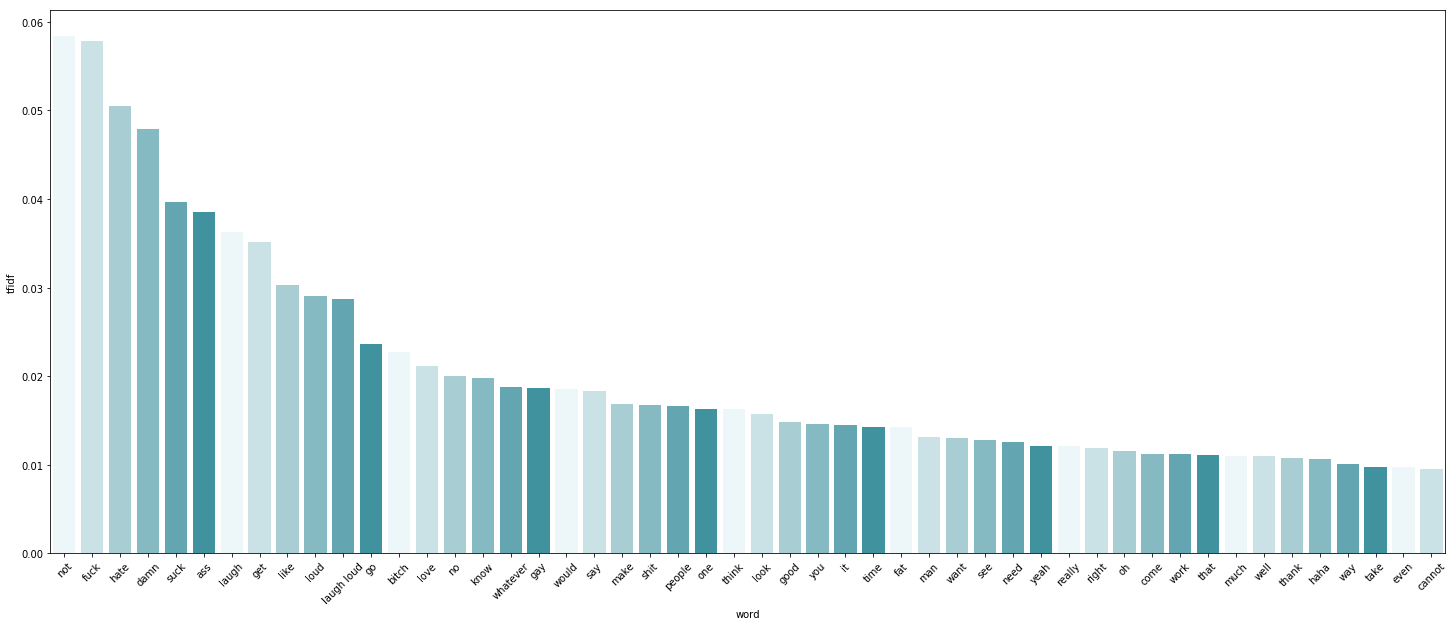

In [44]:
plt.figure(figsize = (25,10))
sns.barplot(x = 'word', y = 'tfidf', data = df_tfidf.head(50), palette = sns.light_palette((210, 90, 60), input = "husl"))
plt.xticks(rotation = 45)
plt.show()

***

**Visualize TF-IDF embeddings**

***

In [37]:
print(repr(x_train_tfidf))

<7943x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 226385 stored elements in Compressed Sparse Row format>


The TF-IDF features form a sparse matrix, which we can try to visualize using a heatmap and select only 100 dimension to preserve a certain visibility.

Text(0.5, 1.0, 'Sparse Matrix 100 Sample')

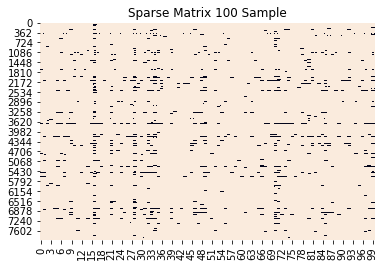

In [38]:
sns.heatmap(x_train_tfidf.todense()
            [:,np.random.randint(0, x_train_tfidf.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix 100 Sample')

One very popular method for visualizing document similarity is to use t-distributed stochastic neighbor embedding, t-SNE.

For high-dimensional sparse data it is helpful to first reduce the dimensions to let's say 50 dimensions with TruncatedSVD and then perform t-SNE. This should improve the visualization.

In [39]:
from sklearn.decomposition import TruncatedSVD
X_red = TruncatedSVD(n_components = 50, random_state = RANDOM_STATE).fit_transform(x_train_tfidf)

An important feature of t-SNE is a tuneable parameter, “perplexity,” which says (loosely) how to balance attention between local and global aspects of the data. The parameter is, in a sense, a guess about the number of close neighbors each point has. The perplexity value has a complex effect on the resulting pictures. The original paper says, “The performance of SNE is fairly robust to changes in the perplexity, and typical values are between 5 and 50.”


My intuition about how the perplexity parameter in t-SNE works is that it sets the effective number of neighbours that each point is attracted to. So if the perplexity is very small, then there will be fewer pairs that feel any attraction and the resulting embedding will tend to be "fluffy".

On the other hand, if the perplexity is large, clusters will tend to shrink into denser structures.

I will try with a relatively low perplexity and a very high perplexity.

In [40]:
from  sklearn.manifold import TSNE
#Perplexity 10
X_tsne = TSNE(n_components = 2, perplexity = 10, verbose = 2).fit_transform(X_red)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 7943 samples in 0.035s...
[t-SNE] Computed neighbors for 7943 samples in 6.759s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7943
[t-SNE] Computed conditional probabilities for sample 2000 / 7943
[t-SNE] Computed conditional probabilities for sample 3000 / 7943
[t-SNE] Computed conditional probabilities for sample 4000 / 7943
[t-SNE] Computed conditional probabilities for sample 5000 / 7943
[t-SNE] Computed conditional probabilities for sample 6000 / 7943
[t-SNE] Computed conditional probabilities for sample 7000 / 7943
[t-SNE] Computed conditional probabilities for sample 7943 / 7943
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.124s
[t-SNE] Iteration 50: error = 104.5089569, gradient norm = 0.0115001 (50 iterations in 3.025s)
[t-SNE] Iteration 100: error = 94.5725937, gradient norm = 0.0060515 (50 iterations in 3.055s)
[t-SNE] Iteration 150: error = 92.7314529, gradient norm = 

Populating the interactive namespace from numpy and matplotlib


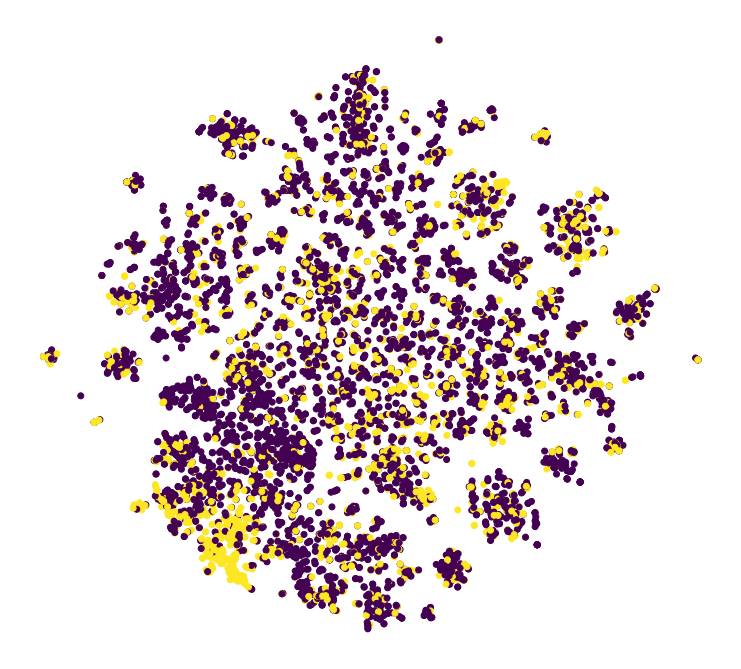

In [41]:
%pylab inline
figure(figsize = (10, 10))
ax = axes(frameon = False)
setp(ax, xticks = (), yticks = ())
subplots_adjust(left = 0.0, bottom = 0.0, right = 1.0, top = 0.9, wspace = 0.0, hspace = 0.0) 
scatter(X_tsne[:, 0], X_tsne[:, 1], c = y_train)

As we noticed when we plotted the top words in each class, we are not able to clearly separate between the two classes. We also do not clearly see the formation of clusters (although perhaps a bit better formed than before), so I will give it another try with a higher perplexity.

In [42]:
#Perplexity 100
X_tsne = TSNE(n_components = 2, perplexity = 100, verbose = 2).fit_transform(X_red)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 7943 samples in 0.029s...
[t-SNE] Computed neighbors for 7943 samples in 7.596s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7943
[t-SNE] Computed conditional probabilities for sample 2000 / 7943
[t-SNE] Computed conditional probabilities for sample 3000 / 7943
[t-SNE] Computed conditional probabilities for sample 4000 / 7943
[t-SNE] Computed conditional probabilities for sample 5000 / 7943
[t-SNE] Computed conditional probabilities for sample 6000 / 7943
[t-SNE] Computed conditional probabilities for sample 7000 / 7943
[t-SNE] Computed conditional probabilities for sample 7943 / 7943
[t-SNE] Mean sigma: 0.156052
[t-SNE] Computed conditional probabilities in 1.099s
[t-SNE] Iteration 50: error = 77.9391022, gradient norm = 0.0001529 (50 iterations in 5.028s)
[t-SNE] Iteration 100: error = 77.5555496, gradient norm = 0.0026598 (50 iterations in 8.490s)
[t-SNE] Iteration 150: error = 76.8174362, gradient norm = 

Populating the interactive namespace from numpy and matplotlib


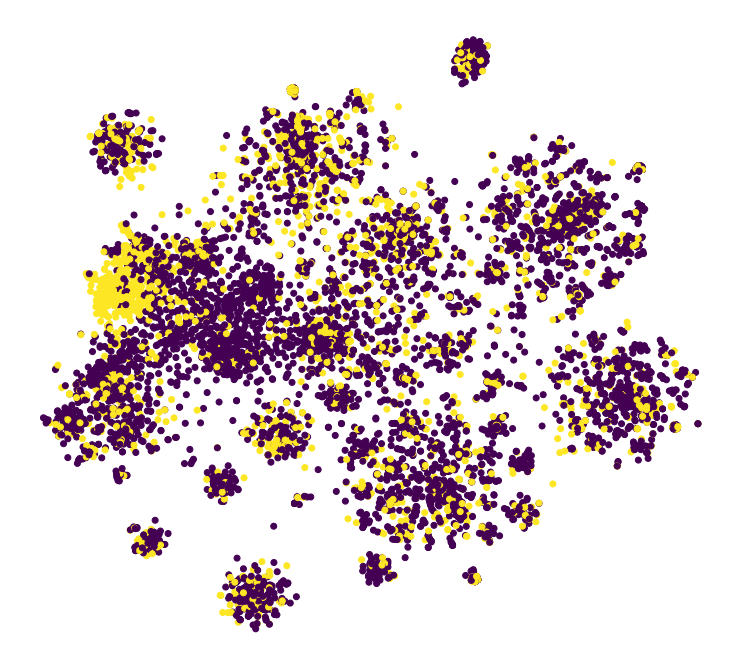

In [43]:
%pylab inline
figure(figsize = (10, 10))
ax = axes(frameon = False)
setp(ax, xticks = (), yticks = ())
subplots_adjust(left = 0.0, bottom = 0.0, right = 1.0, top = 0.9, wspace = 0.0, hspace = 0.0) 
scatter(X_tsne[:, 0], X_tsne[:, 1], c = y_train)

Here we notice a stronger formation of clustering. Maybe increasing the perplexity would help, but probably not by much, since we already know that we have very little separation between the classes.

The two classes do not look very well separated, which could in theory be a feature of our embeddings or simply of our dimensionality reduction. Since we already know the classes are overlapping, we can safely say it's a feature of our embeddings.